In [1]:
setwd('/home/other/jpf5265/DnDs-visualization/test_dataset/')

In [6]:
library(tidyverse)
library(viridis)
library(patchwork)
library(ggraph)
library(igraph)

In [7]:
library(dplyr)
# Load the datasets
taxonomy <- read.csv('marinus_taxonomy.csv')
dnds <- read.csv('dnds_constant_15.csv')

# Drop rows where column dNdS_ratio or column dNdS_ratio_constant is NA
dnds <- dnds %>%
  filter(!is.na(dNdS_ratio) & !is.na(dNdS_ratio_constant)) %>%
  select(X, A, B, dNdS_ratio_constant)

In [18]:
# Add a root column to the taxonomy data, reshape the data into long format
taxonomy_long <- taxonomy %>%
  select(custom_fasta_name, phylum, class, order, family, genus, species) %>%
  mutate(Root = "Root") %>%

  # Create hierarchical relationships
  pivot_longer(cols = c(Root, phylum, class, order, family, genus, species, custom_fasta_name),
               names_to = "level",
               values_to = "name")%>%
  mutate(genome_id = rep(taxonomy$custom_fasta_name, each = 8))


# Create hierarchical relationships
hierarchy <- taxonomy_long %>%

  # sorting taxomomic lelvel within each genome ("genome_id")
  arrange(genome_id, match(level, c("Root", "phylum", "class", "order", "family", "genus", "species", "custom_fasta_name"))) %>%
  group_by(genome_id) %>%

  # from = lag(name): Take the value from the previous row in the column "name" and assigns it to a new column called from, 
  # to = name: Set the value in column "to" the value in the name column.
  mutate(from = lag(name), to = name)  %>%
  filter(!is.na(from)) %>%
  select(from, to) %>%
  distinct() %>%
  ungroup() %>%
  distinct(from, to)

Adding missing grouping variables: `genome_id`


In [15]:
vertices <- data.frame(name = unique(c(as.character(hierarchy$from), as.character(hierarchy$to))))
# Count the number of vertices so that we can generates the same numbers of random values uniformly distributed between 0 and 1
nrow(vertices)

[1] 31

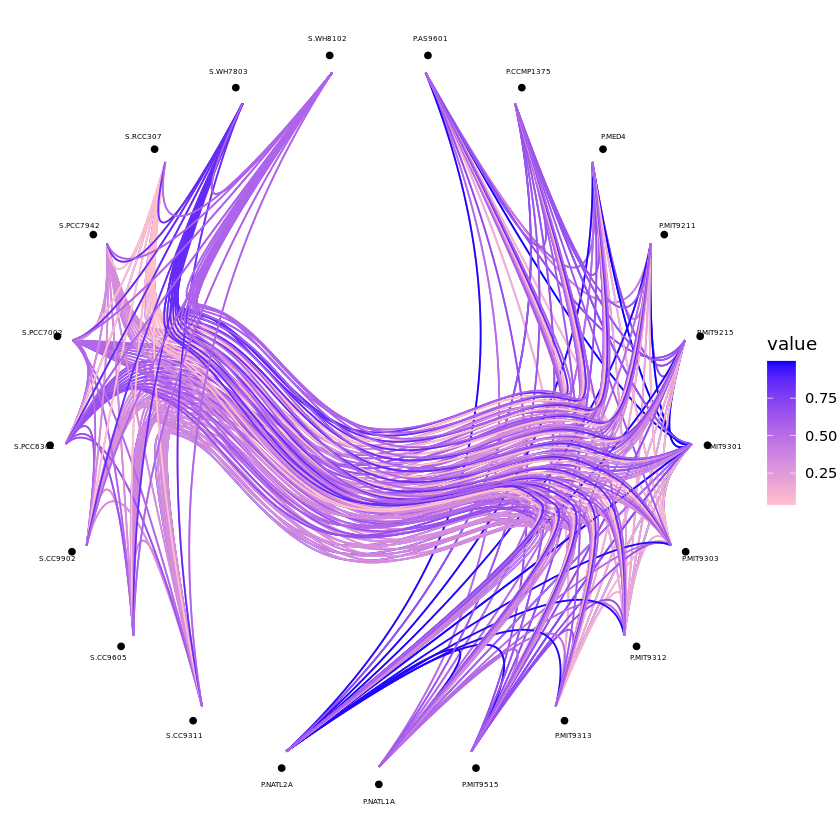

In [22]:
set.seed(399)
vertices <- data.frame(name = unique(c(as.character(hierarchy$from), as.character(hierarchy$to))), value = runif(31)) 
mygraph <- graph_from_data_frame( hierarchy, vertices=vertices )

connect <- dnds %>%
  rename(from = A, to = B, dndsvalue = dNdS_ratio_constant) %>%
  select(from, to, dndsvalue) 


# # Choose two genomes (e.g., P.AS9601 and S.CC9311) which belong to two different families to test the visualization
# connect <- dnds %>%
#   rename(from = A, to = B, dndsvalue = dNdS_ratio_constant) %>%
#   select(from, to, dndsvalue) %>%
#   filter(from %in% c("P.AS9601", "S.CC9311"))

from <- match( connect$from, vertices$name)
to <- match( connect$to, vertices$name)


mygraph <- graph_from_data_frame( hierarchy, vertices=vertices )
# # # ggraph(mygraph, layout = 'dendrogram', circular = TRUE) + 
# # # geom_conn_bundle(data = get_con(from = from, to = to), alpha=0.2, colour="skyblue", tension = 0.9) +
# # # geom_node_point(aes(filter = leaf, x = x*1.05, y=y*1.05)) +
# # # geom_node_text(aes(x = x*1.1, y=y*1.1, filter = leaf, label=name), size=1.5, alpha=1) +
# # # theme_void()


p <- ggraph(mygraph, layout = 'dendrogram', circular = TRUE) + 
  geom_node_point(aes(filter = leaf, x = x*1.05, y=y*1.05)) +
  theme_void()

p + geom_conn_bundle(data = get_con(from = from, to = to), aes(colour=value)) +
  scale_edge_color_continuous(low="pink", high="blue") + geom_node_text(aes(x = x*1.1, y=y*1.1, filter = leaf, label=name), size=1.5, alpha=1)



